In [2]:
from matplotlib import pyplot as plt

import xarray as xr
import netCDF4 as nc
import numpy as np

import os

import datetime as dt
import pickle

from sklearn.model_selection import train_test_split
from sklearn.linear_model import RidgeCV, Ridge, LinearRegression, Lasso, ElasticNet
from sklearn.metrics import r2_score
import random
from tqdm import tqdm
from collections import Counter

In [3]:
models = ['CanESM5', 'MIROC-ES2L', 'MPI-ESM1-2-LR', 'MIROC6', 'CESM2']

In [5]:
def load_model_data(model, var, path='../data/'):
    # Loading data file
    file_path = os.path.join(path, '{}_{}.nc'.format(model, var))
    ds = xr.open_dataset(file_path)
    # Getting TAS
    tas_array = ds[var].values
    # Close the dataset
    ds.close()
    return tas_array

def get_data_shape_lat_lon(model='CanESM5', var='tas', path='../data/'):
    file_path = os.path.join(path, '{}_{}.nc'.format(model, var))
    ds = xr.open_dataset(file_path)
    # Getting TAS
    shape = ds[var].values.shape
    # Close the dataset
    ds.close()
    return shape, ds['lat'], ds['lon']

def load_data_models(models, var='tas', n_sample=10, path='../data/'):
    X, y = None, None
    for model in models:
        tas_array = load_model_data(model, var=var, path=path)
        shape = tas_array.shape
        
        idxs = random.sample(range(shape[0]*shape[1]), n_sample)
        X_temp = tas_array.reshape(shape[0]*shape[1], shape[2]*shape[3])
        y_temp = np.tile(tas_array.mean(axis=0), (shape[0], 1, 1)) .reshape(shape[0]*shape[1], shape[2]*shape[3])

        if X is None:
            X = X_temp[idxs,:]
            y = y_temp[idxs,:]
        else :
            X = np.vstack((X, X_temp[idxs,:]))
            y = np.vstack((y, y_temp[idxs,:]))
        del tas_array
        del X_temp
        del y_temp
    return X, y

In [6]:
shape, lat, lon = get_data_shape_lat_lon()
d = shape[2]*shape[3]

In [7]:
B = 50
models_test = random.choices(models, k=B)
models_train = [[model for model in models if model != model_test ] for model_test in models_test ]

In [8]:
occurence_models_test = Counter(models_test)

In [9]:
occurence_models_test

Counter({'MIROC6': 8,
         'MIROC-ES2L': 11,
         'CESM2': 11,
         'CanESM5': 9,
         'MPI-ESM1-2-LR': 11})

In [10]:
N = 2500
n_alpha = 20
alphas = np.logspace(3, 6, n_alpha)

In [ ]:
for alpha in tqdm(alphas):
    weights = {model: None for model in models}
    for m_train, m_test in zip(models_train, models_test):
        print(m_test)
        X_train, Y_train = load_data_models(m_train, n_sample=N)
        X_test, Y_test = load_data_models([m_test], n_sample=N)
        ridge = Ridge(alpha)
        ridge.fit(X_train, Y_train)
        if weights[m_test] is None:
            weights[m_test] = np.hstack((ridge.coef_/occurence_models_test[m_test], (ridge.intercept_/occurence_models_test[m_test])[:,None]))
        else:
            weights[m_test] += np.hstack((ridge.coef_/occurence_models_test[m_test], (ridge.intercept_/occurence_models_test[m_test])[:,None]))
    
    # Save the weights for this alpha to a file
    file_path = f'../weights/Ridge_weights_alpha_{alpha}_n{N}.pkl'
    with open(file_path, 'wb') as f:
        pickle.dump(weights, f)

  0%|                                                                 | 0/20 [00:00<?, ?it/s]

MIROC6
MPI-ESM1-2-LR
MIROC6
MIROC-ES2L
CESM2
MIROC6
MPI-ESM1-2-LR
MIROC-ES2L
CESM2
CanESM5
MIROC-ES2L
MIROC-ES2L
CanESM5
CanESM5
MIROC-ES2L
CESM2
CESM2
CESM2
MIROC-ES2L
CESM2
MPI-ESM1-2-LR
CanESM5
MPI-ESM1-2-LR
MIROC6
CESM2
CanESM5
CESM2


In [11]:
# Directory path
directory = '../weights/'

# List all files in the directory
files = os.listdir(directory)

In [13]:
R=10
scores = {}
scores_pattern = {}
for file in tqdm(files):
    alpha = file[20:-11]
    scores[alpha] = []
    scores_pattern[alpha] = np.zeros(d)
    for model in ['CanESM5', 'MPI-ESM1-2-LR']:
        #file_path = f'../weights/Ridge_weights_alpha_{alpha}_n{N}.pkl'
        for _ in range(R) :
            with open(directory + file, 'rb') as f:
                weights = pickle.load(f)
            X_test, Y_test = load_data_models([model], var='tas')
            A, B = weights[model][:,:-1], weights[model][:,-1]
            Y_pred = X_test @ A.T + B 
            score_pattern = r2_score(Y_test, Y_pred, multioutput='raw_values')
            scores_pattern[alpha] += score_pattern/(len(models)*R)
            scores[alpha].append(score_pattern.mean())

100%|████████████████████████████████████████████████████████| 14/14 [06:00<00:00, 25.77s/it]


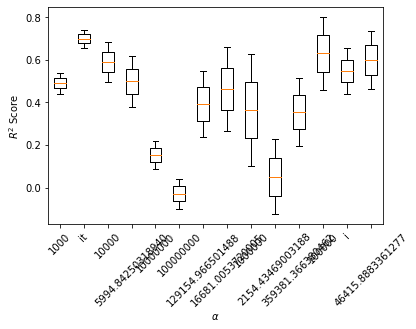

In [14]:
import matplotlib.pyplot as plt

# Extract scores for each alpha
data = [scores[alpha] for alpha in scores.keys()]

# Boxplot
plt.boxplot(data)

# Set xticklabels with alpha values
plt.xticks(range(1, len(scores.keys()) + 1), [alpha for alpha in scores.keys()], rotation=45)

# Set xlabel with alphas
plt.xlabel(r'$\alpha$')

# Set ylabel with r2 score
plt.ylabel(r'$R^2$ Score')

plt.show()


In [20]:
scores

{'1000': [0.5397252382407284, 0.4417931951981148],
 'it': [0.7408274422118994, 0.6582398677963833],
 '10000': [0.6842975580275281, 0.4946023281569727],
 '5994.84250318940': [0.37995424053910304, 0.6190485668206485],
 '10000000': [0.0877705423566501, 0.21729918221836594],
 '100000000': [-0.10120029338895752, 0.04179852101670144],
 '129154.966501488': [0.23537863015901045, 0.5493600763802747],
 '16681.0053720005': [0.6626842573916715, 0.26668561772518024],
 '1000000': [0.10274835578689531, 0.6270718057955013],
 '2154.43469003188': [-0.12622012907126082, 0.22878137708753893],
 '359381.366380462': [0.5156661366839113, 0.19416033180824085],
 '100000': [0.8035258012237352, 0.45800613404475427],
 'i': [0.6553082695307431, 0.4416044800284756],
 '46415.8883361277': [0.737881504766604, 0.46167008689541494]}

In [18]:
mean_scores = {alpha: np.mean(scores[alpha]) for alpha in scores.keys()}

In [ ]:
alpha_opt = alphas[np.argmax(list(mean_scores.values()))]

In [ ]:
scores_pattern_maps = scores_pattern[alpha_opt].reshape(len(lat), len(lon))

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from matplotlib.colors import TwoSlopeNorm

# Assuming you have defined lat, lon, diff_r2_map, diff_corr_map, max_val_r2, max_val_corr

# Plotting
fig = plt.figure(figsize=(10, 6))
ax = plt.axes(projection=ccrs.Robinson())

# Plot for diff_r2_map
norm_r2 = TwoSlopeNorm(vmin=-1.0, vcenter=0, vmax=1.0)
contour_r2 = ax.pcolormesh(lon, lat, scores_pattern_maps, transform=ccrs.PlateCarree(), cmap='coolwarm', norm=norm_r2)
ax.coastlines()

gl = ax.gridlines(draw_labels=True)
gl.top_labels = gl.right_labels = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 12}  # Longitude font size
gl.ylabel_style = {'size': 12}  # Latitude font size

ax.set_title(r'Explained variance of optimal fingerprint with $\alpha={:.0f}$'.format(alpha_opt), fontsize=15)

cb = plt.colorbar(contour_r2, ax=ax, label='R2 score differences', orientation='horizontal')
cb.ax.tick_params(labelsize=12)
cb.set_label(r'$R^2$ ', fontsize=12) 

directory = '../Results'
plt.savefig(directory + "/maps_R2_ridge_alpha{}.pdf".format(alpha), format="pdf", bbox_inches="tight")


plt.show()

Potential improvement:
* Dynamical adjustment as a preprocessing to first remove **"Internal Variability"**.
* Using anchor regression to make prediction less sensitive to some specific pattern of variability (e.g. North Atlantic Oscillation)
* Using a model for each month (making the data more linear???)
* Using a nonlinear model (Kernel Ridge, Random Forest, etc...)